# Import packages

In [1]:
# loading packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import seaborn as sns
plt.rcParams['figure.dpi'] = 300

import matplotlib.dates as mdates

# ignoring warnings
import warnings
warnings.simplefilter("ignore")

In [2]:
import sklearn as sk
import statsmodels.api as sm

# Import Statsmodels
from statsmodels.tsa.api import VAR
from statsmodels.tsa.api import ARMA


from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse, aic
from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from statsmodels.stats.stattools import durbin_watson

from sklearn.metrics import r2_score,mean_squared_error
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV

import copy

# Custom functions

In [3]:
def diff_for_stationarity(df_input,cols,threshold):
    
    """Checks the series for stationarity then difference it until it is stationary
    (with the given threshold)"""
    
    df = copy.deepcopy(df_input)
    
    
    # Get length of DF
    n = len(df)
    
    # Loop over columns of interest
    for col in cols:
        stationarity = False
        series = list(df[col].astype(float))
        linear_diff = False
        
        try:
        
            counter = 0



            while not stationarity:

                #print(counter)

                # Run ADF test
                adf_test = adfuller(series)
                pval = adf_test[1]

                if pval < threshold:
                    stationarity = True

                else:
                    # Difference the series
                    #series = [np.log(series[i]/series[i-1]) for i in range(1,n-counter)]
                    series = [series[i]-series[i-1] for i in range(1,n-counter)]

                    counter += 1
                    
        except:
            
            counter = 0
            stationarity = False
            series = list(df[col].astype(float))
            linear_diff = True

            while not stationarity:

                #print(counter)

                # Run ADF test
                adf_test = adfuller(series)
                pval = adf_test[1]

                if pval < threshold:
                    stationarity = True

                elif counter>1:
                    stationarity = True
                    series = list(df[col].astype(float))
                else:
                    # Difference the series
                    series = [series[i]-series[i-1] for i in range(1,n-counter)]

                    counter += 1
        
        # Create final series and assign it back to the dataframe
        final_series = [None]*counter + series
        df[col] = final_series
        
        if linear_diff:
            type_diff = "linear difference"
        else:
            type_diff = "linear difference"
        
        print("Variable: {} is {}-order integrated ({})!".format(col,counter,type_diff))
        
        
    return df

In [4]:
def bar_plot(x, y, title, palette_len, xlim = None, ylim = None, 
             xticklabels = None, yticklabels = None, 
             top_visible = False, right_visible = False, 
             bottom_visible = True, left_visible = False,
             xlabel = None, ylabel = None, figsize = (10, 4),
             axis_grid = 'y'):
    fig, ax = plt.subplots(figsize = figsize)
    plt.title(title, size = 15, fontweight = 'bold', fontfamily = 'serif')

    for i in ['top', 'right', 'bottom', 'left']:
        ax.spines[i].set_color('black')
    
    ax.spines['top'].set_visible(top_visible)
    ax.spines['right'].set_visible(right_visible)
    ax.spines['bottom'].set_visible(bottom_visible)
    ax.spines['left'].set_visible(left_visible)

    sns.barplot(x = x, y = y, edgecolor = 'black', ax = ax,
                palette = reversed(sns.color_palette("viridis", len(palette_len))))
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)    
    ax.set_xticklabels(xticklabels, fontfamily = 'serif')
    ax.set_yticklabels(yticklabels, fontfamily = 'serif')
    plt.xlabel(xlabel, fontfamily = 'serif')
    plt.ylabel(ylabel, fontfamily = 'serif')
    ax.grid(axis = axis_grid, linestyle = '--', alpha = 0.9)
    plt.show()

# Import data

In [5]:
print('Datasets:')
os.listdir('./Data/acea-water-prediction')

Datasets:


['Aquifer_Auser.csv',
 'River_Arno.csv',
 'Lake_Bilancino.csv',
 'Aquifer_Petrignano.csv',
 'Aquifer_Doganella.csv',
 'Water_Spring_Lupa.csv',
 'Water_Spring_Madonna_di_Canneto.csv',
 'datasets_description.ods',
 'Water_Spring_Amiata.csv',
 'Aquifer_Luco.csv']

In [6]:
Aquifer_Doganella = pd.read_csv('./Data/acea-water-prediction/Aquifer_Doganella.csv', index_col = 'Date')
Aquifer_Auser = pd.read_csv('./Data/acea-water-prediction/Aquifer_Auser.csv', index_col = 'Date')
Water_Spring_Amiata = pd.read_csv('./Data/acea-water-prediction/Water_Spring_Amiata.csv', index_col = 'Date')
Lake_Bilancino = pd.read_csv('./Data/acea-water-prediction/Lake_Bilancino.csv', index_col = 'Date')
Water_Spring_Madonna_di_Canneto = pd.read_csv('./Data/acea-water-prediction/Water_Spring_Madonna_di_Canneto.csv', index_col = 'Date')
Aquifer_Luco = pd.read_csv('./Data/acea-water-prediction/Aquifer_Luco.csv', index_col = 'Date')
Aquifer_Petrignano = pd.read_csv('./Data/acea-water-prediction/Aquifer_Petrignano.csv', index_col = 'Date')
Water_Spring_Lupa = pd.read_csv('./Data/acea-water-prediction/Water_Spring_Lupa.csv', index_col = 'Date')
River_Arno = pd.read_csv('./Data/acea-water-prediction/River_Arno.csv', index_col = 'Date')

print('Datasets shape:')
print('*'*30)
print('Aquifer_Doganella: {}'.format(Aquifer_Doganella.shape))
print('Aquifer_Auser: {}'.format(Aquifer_Auser.shape))
print('Water_Spring_Amiata: {}'.format(Water_Spring_Amiata.shape))
print('Lake_Bilancino: {}'.format(Lake_Bilancino.shape))
print('Water_Spring_Madonna_di_Canneto: {}'.format(Water_Spring_Madonna_di_Canneto.shape))
print('Aquifer_Luco: {}'.format(Aquifer_Luco.shape))
print('Aquifer_Petrignano: {}'.format(Aquifer_Petrignano.shape))
print('Water_Spring_Lupa: {}'.format(Water_Spring_Lupa.shape))
print('River_Arno: {}'.format(River_Arno.shape))

Datasets shape:
******************************
Aquifer_Doganella: (6026, 21)
Aquifer_Auser: (8154, 26)
Water_Spring_Amiata: (7487, 15)
Lake_Bilancino: (6603, 8)
Water_Spring_Madonna_di_Canneto: (3113, 3)
Aquifer_Luco: (7487, 21)
Aquifer_Petrignano: (5223, 7)
Water_Spring_Lupa: (4199, 2)
River_Arno: (8217, 16)


# EDA

In [5]:
datasets = [Aquifer_Doganella, Aquifer_Auser, Water_Spring_Amiata,
            Lake_Bilancino, Water_Spring_Madonna_di_Canneto, Aquifer_Luco,
            Aquifer_Petrignano, Water_Spring_Lupa, River_Arno]

datasets_names = ['Aquifer_Doganella', 'Aquifer_Auser', 'Water_Spring_Amiata',
                'Lake_Bilancino', 'Water_Spring_Madonna_di_Canneto', 'Aquifer_Luco',
                'Aquifer_Petrignano', 'Water_Spring_Lupa', 'River_Arno']

In [6]:
print('Datasets dtypes:')
print('*'*30)
for i in range(len(datasets)):
    print('{}: \n{}'.format(datasets_names[i], datasets[i].dtypes.value_counts()))
    print('-'*20)

Datasets dtypes:
******************************
Aquifer_Doganella: 
float64    21
dtype: int64
--------------------
Aquifer_Auser: 
float64    26
dtype: int64
--------------------
Water_Spring_Amiata: 
float64    15
dtype: int64
--------------------
Lake_Bilancino: 
float64    8
dtype: int64
--------------------
Water_Spring_Madonna_di_Canneto: 
float64    3
dtype: int64
--------------------
Aquifer_Luco: 
float64    21
dtype: int64
--------------------
Aquifer_Petrignano: 
float64    7
dtype: int64
--------------------
Water_Spring_Lupa: 
float64    2
dtype: int64
--------------------
River_Arno: 
float64    16
dtype: int64
--------------------


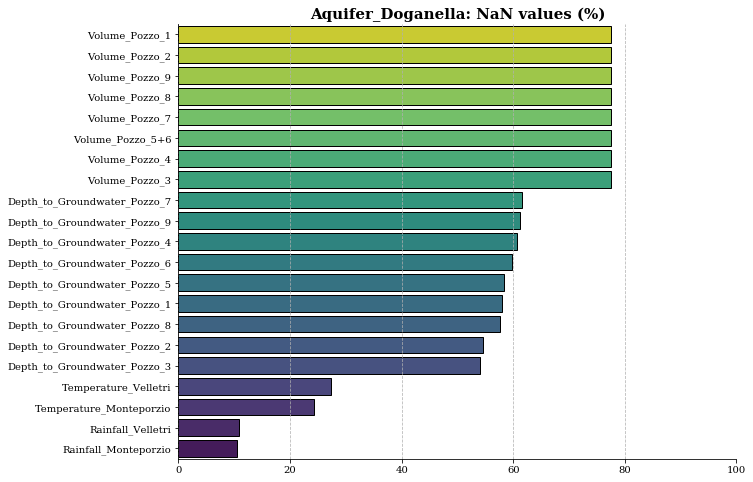

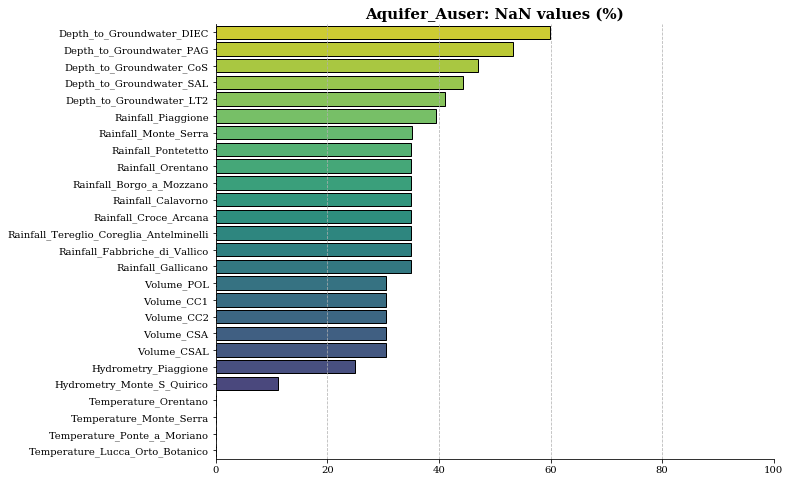

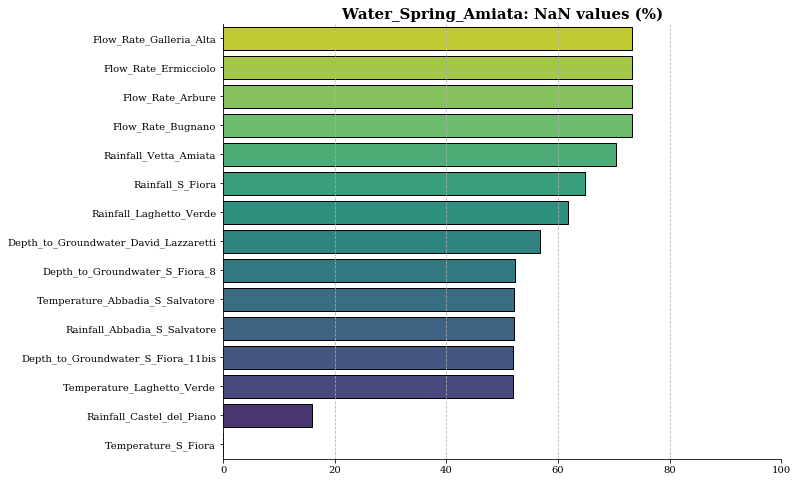

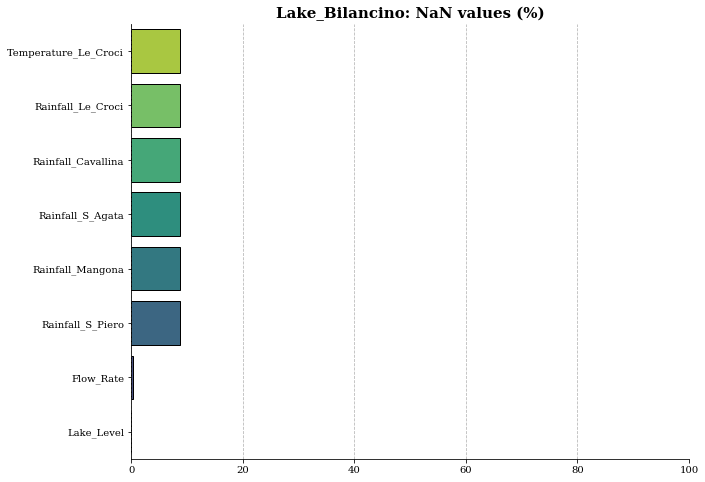

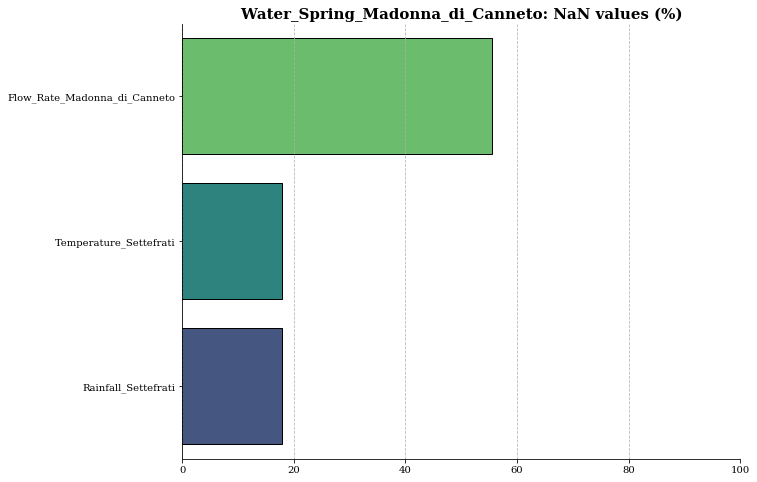

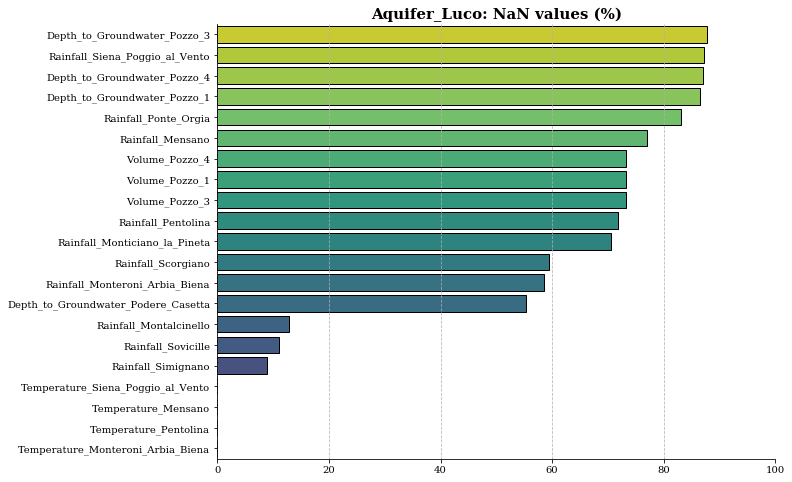

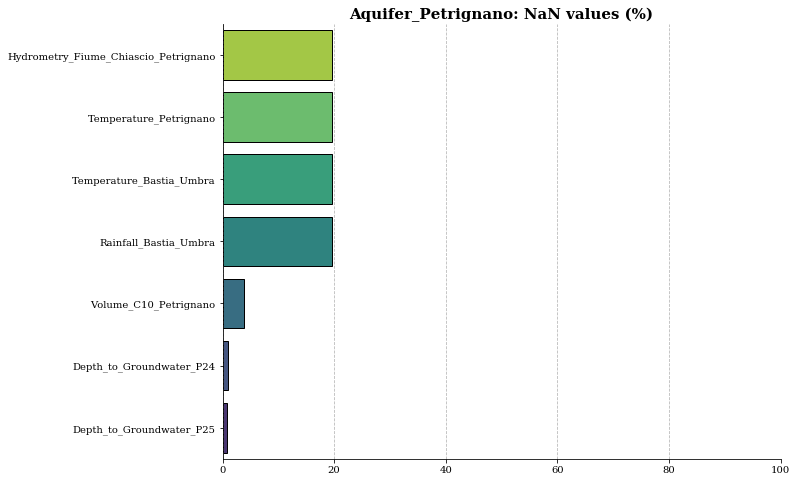

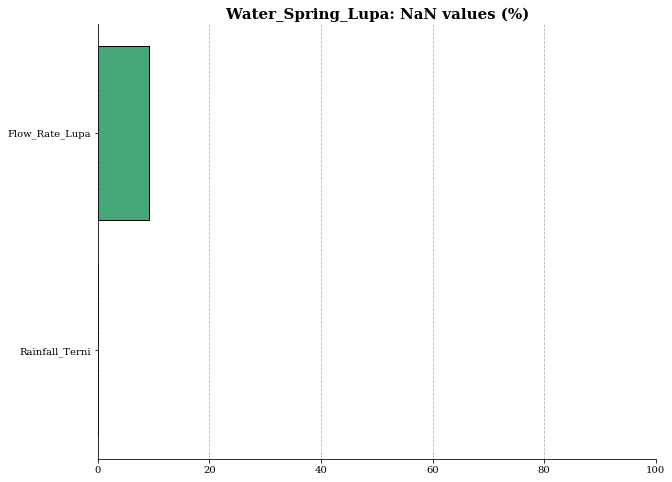

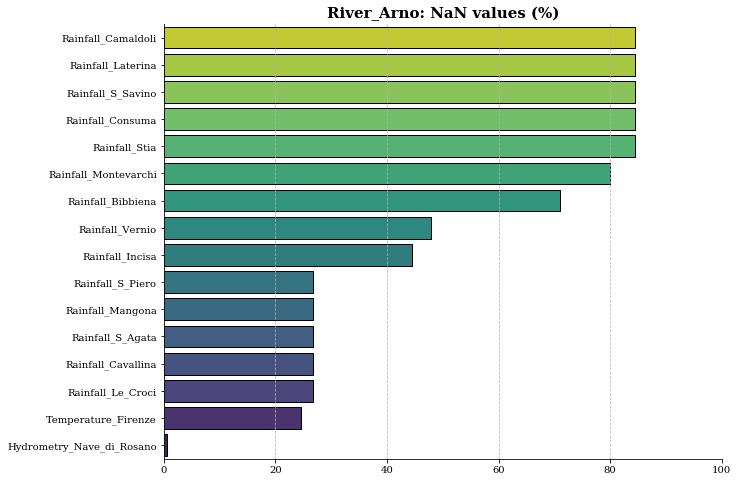

In [7]:
for i in range(len(datasets)):
    NaN_values = (datasets[i].isnull().sum() / len(datasets[i]) * 100).sort_values(ascending = False)
    bar_plot(x = NaN_values, 
             y = NaN_values.index,
             title = '{}: NaN values (%)'.format(datasets_names[i]),
             palette_len = NaN_values.index, 
             xlim = (0, 100), 
             xticklabels = range(0, 101, 20),
             yticklabels = NaN_values.index,
             left_visible = True,
             figsize = (10, 8), axis_grid = 'x')

## Aquifer Luca

In [8]:
datasets[5].head()


,Rainfall_Simignano,Rainfall_Siena_Poggio_al_Vento,Rainfall_Mensano,Rainfall_Montalcinello,Rainfall_Monticiano_la_Pineta,Rainfall_Sovicille,Rainfall_Ponte_Orgia,Rainfall_Scorgiano,Rainfall_Pentolina,Rainfall_Monteroni_Arbia_Biena,...,Depth_to_Groundwater_Pozzo_1,Depth_to_Groundwater_Pozzo_3,Depth_to_Groundwater_Pozzo_4,Temperature_Siena_Poggio_al_Vento,Temperature_Mensano,Temperature_Pentolina,Temperature_Monteroni_Arbia_Biena,Volume_Pozzo_1,Volume_Pozzo_3,Volume_Pozzo_4
Date,,,,,,,,,,,,,,,,,,,,,
01/01/2000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.0,0.0,5.50,0.80,NaN,NaN,NaN
02/01/2000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.0,0.0,6.20,3.25,NaN,NaN,NaN
03/01/2000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.0,0.0,7.25,0.95,NaN,NaN,NaN
04/01/2000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.0,0.0,7.00,4.20,NaN,NaN,NaN
05/01/2000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.0,0.0,7.90,6.55,NaN,NaN,NaN


In [9]:
print('The earliest date: \t%s' %datasets[5].index.values[[0, -1]][0])
print('The latest date: \t%s' %datasets[5].index.values[[0, -1]][1])

The earliest date: 	01/01/2000
The latest date: 	30/06/2020


## River Arno

In [43]:
df = River_Arno[['Hydrometry_Nave_di_Rosano', 'Temperature_Firenze']].reset_index()
df['rainfall'] = River_Arno.iloc[:, 0:-2].sum(axis = 1).values
df['year'] = pd.to_datetime(df.Date).dt.year
df['month'] = pd.to_datetime(df.Date).dt.month

# Monthly dynamics
df['month_year'] = pd.to_datetime(df.Date).apply(lambda x: x.strftime('%Y/%m'))

r_means = np.log(df.groupby('month_year').Hydrometry_Nave_di_Rosano.mean() * 10).reset_index()
r_means['month_year'] = pd.to_datetime(r_means['month_year'])

r_rain = np.log(df.groupby('month_year').rainfall.mean()).reset_index()
r_rain['month_year'] = pd.to_datetime(r_rain['month_year'])

r_temp = np.log(df.groupby('month_year').Temperature_Firenze.mean()).reset_index()
r_temp['month_year'] = pd.to_datetime(r_temp['month_year'])

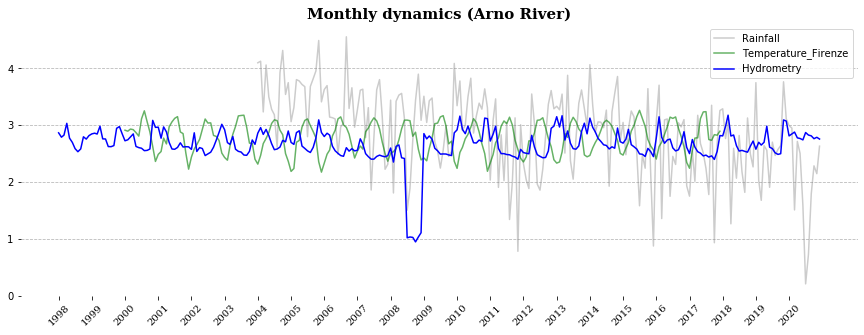

In [44]:
fig, ax = plt.subplots(figsize = (15, 5))
plt.title('Monthly dynamics (Arno River)', size = 15, fontweight = 'bold', fontfamily = 'serif')

sns.lineplot(data = r_rain, x = 'month_year', y = 'rainfall', 
             color = 'gray', label = 'Rainfall', alpha = 0.4)
plt.xticks(rotation = 45)
sns.lineplot(data = r_temp, x = 'month_year', y = 'Temperature_Firenze', 
             color = 'green', label = 'Temperature_Firenze', alpha = 0.6)
plt.xticks(rotation = 45)
sns.lineplot(data = r_means, x = 'month_year', y = 'Hydrometry_Nave_di_Rosano', 
             color = 'blue', label = 'Hydrometry')
plt.xticks(rotation = 45)
    
for i in ['top', 'right', 'bottom', 'left']:
        ax.spines[i].set_visible(False)

ax.set_xticks(r_means.month_year[::12])
ax.set_xticklabels(range(1998, 2021, 1), fontfamily = 'serif')
ax.set_xlabel('')
ax.set_ylabel('')
ax.grid(axis = 'y', linestyle = '--', alpha = 0.9)
plt.show()

In [45]:
River_Arno.describe()

,Rainfall_Le_Croci,Rainfall_Cavallina,Rainfall_S_Agata,Rainfall_Mangona,Rainfall_S_Piero,Rainfall_Vernio,Rainfall_Stia,Rainfall_Consuma,Rainfall_Incisa,Rainfall_Montevarchi,Rainfall_S_Savino,Rainfall_Laterina,Rainfall_Bibbiena,Rainfall_Camaldoli,Temperature_Firenze,Hydrometry_Nave_di_Rosano
count,6026.000000,6026.000000,6026.000000,6026.000000,6026.000000,4283.000000,1283.000000,1283.000000,4568.000000,1647.000000,1283.00000,1283.000000,2378.000000,1283.000000,6192.000000,8169.000000
mean,3.129871,2.674743,2.670063,3.340657,2.471225,3.416437,2.538893,3.416680,2.335026,2.056709,2.42650,2.101949,2.640959,3.826968,16.605386,1.472407
std,8.025121,7.655847,7.166643,8.903134,6.650012,9.425358,6.502917,8.938863,6.347652,6.117967,7.23414,6.377879,7.161416,9.591337,7.458951,0.616259
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,-2.700000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,10.650000,1.100000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,16.350000,1.300000
75%,1.200000,0.600000,1.200000,1.400000,0.800000,1.200000,1.000000,2.200000,0.800000,0.600000,0.70000,0.400000,1.200000,2.400000,22.700000,1.690000
max,88.400000,113.600000,120.200000,110.000000,80.600000,126.000000,63.000000,114.400000,102.200000,75.000000,123.20000,95.600000,77.400000,103.600000,34.900000,6.750000


# Data preprocessing

## Handle missing values

In [7]:
River_Arno = River_Arno.fillna(method='bfill')

In [8]:
print(River_Arno.shape)

# Add averages isntead of still missing values
River_Arno = River_Arno.fillna(River_Arno.mean())

# Drop rows with NaN value
River_Arno = River_Arno.dropna()
print(River_Arno.shape)

(8217, 16)
(8217, 16)


In [9]:
River_Arno.describe()

,Rainfall_Le_Croci,Rainfall_Cavallina,Rainfall_S_Agata,Rainfall_Mangona,Rainfall_S_Piero,Rainfall_Vernio,Rainfall_Stia,Rainfall_Consuma,Rainfall_Incisa,Rainfall_Montevarchi,Rainfall_S_Savino,Rainfall_Laterina,Rainfall_Bibbiena,Rainfall_Camaldoli,Temperature_Firenze,Hydrometry_Nave_di_Rosano
count,8217.000000,8217.000000,8217.000000,8217.000000,8217.000000,8217.000000,8217.000000,8217.000000,8217.000000,8217.00000,8217.000000,8217.000000,8217.000000,8217.000000,8217.000000,8217.000000
mean,2.295315,1.961543,2.064768,2.449897,1.812292,2.260210,0.937381,1.261831,1.577870,0.99651,0.896143,0.776281,1.374524,1.413356,17.875835,1.472885
std,7.010266,6.661891,6.218677,7.765961,5.798613,6.954087,2.689504,3.690200,4.835322,2.80950,2.957318,2.604286,3.975644,3.974524,7.163059,0.614846
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,-2.700000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.20000,0.000000,0.000000,0.000000,0.000000,12.500000,1.100000
50%,0.000000,0.000000,0.200000,0.000000,0.000000,0.000000,0.937381,1.261831,0.000000,0.99651,0.896143,0.776281,1.374524,1.413356,17.875835,1.310000
75%,0.200000,0.000000,0.400000,0.200000,0.200000,2.260210,0.937381,1.261831,1.577870,0.99651,0.896143,0.776281,1.374524,1.413356,24.650000,1.690000
max,88.400000,113.600000,120.200000,110.000000,80.600000,126.000000,63.000000,114.400000,102.200000,75.00000,123.200000,95.600000,77.400000,103.600000,34.900000,6.750000


## Stationarity checks

In [10]:
# Parameters
stacioner_threshold = 0.01
arno_cols = River_Arno.columns
current_df = River_Arno

# Check for stationarity
df_stationer = diff_for_stationarity(df_input=current_df,cols=arno_cols,threshold=stacioner_threshold)

Variable: Rainfall_Le_Croci is 0-order integrated (linear difference)!
Variable: Rainfall_Cavallina is 0-order integrated (linear difference)!
Variable: Rainfall_S_Agata is 0-order integrated (linear difference)!
Variable: Rainfall_Mangona is 0-order integrated (linear difference)!
Variable: Rainfall_S_Piero is 0-order integrated (linear difference)!
Variable: Rainfall_Vernio is 0-order integrated (linear difference)!
Variable: Rainfall_Stia is 0-order integrated (linear difference)!
Variable: Rainfall_Consuma is 0-order integrated (linear difference)!
Variable: Rainfall_Incisa is 0-order integrated (linear difference)!
Variable: Rainfall_Montevarchi is 0-order integrated (linear difference)!
Variable: Rainfall_S_Savino is 0-order integrated (linear difference)!
Variable: Rainfall_Laterina is 0-order integrated (linear difference)!
Variable: Rainfall_Bibbiena is 0-order integrated (linear difference)!
Variable: Rainfall_Camaldoli is 0-order integrated (linear difference)!
Variable: Tem

## Create train and test

In [11]:
n = len(df_stationer)
testsize = 0.2

test_obs = int(n*testsize)
df_train, df_test = df_stationer[0:-test_obs], df_stationer[-test_obs:]

# Check size
print(df_train.shape)  # (84, 12)
print(df_test.shape)  # (20, 12)

(6574, 16)
(1643, 16)


# Modelling

## ARMA(p,q)

In [12]:
# Fit the model
res = sm.tsa.arma_order_select_ic(df_train['Hydrometry_Nave_di_Rosano'], ic=["aic", "bic","hqic"], trend="nc")

In [13]:
print(res)

{'aic':              0             1             2
0          NaN  17035.480133  12372.258939
1  1987.442139   1987.979487   1766.514753
2  1988.418708   1511.620593   1416.986273
3  1848.956812   1416.884009   1418.386522
4  1770.113894   1418.465005   1405.426160, 'bic':              0             1             2
0          NaN  17049.061888  12392.631572
1  2001.023895   2008.352120   1793.678264
2  2008.791341   1538.784104   1450.940662
3  1876.120323   1450.838398   1459.131788
4  1804.068283   1459.210271   1452.962305, 'hqic':              0             1             2
0          NaN  17040.174991  12379.301226
1  1992.136997   1995.021774   1775.904469
2  1995.460995   1521.010309   1428.723418
3  1858.346529   1428.621155   1432.471097
4  1781.851040   1432.549580   1421.858164, 'aic_min_order': (4, 2), 'bic_min_order': (3, 1), 'hqic_min_order': (4, 2)}


In [14]:
# Parameters
order = (3,1)

# Initialise model
arma_model = ARMA(df_train['Hydrometry_Nave_di_Rosano'],order)

In [15]:
# Fit the model with the selected order
arma_model_fitted = arma_model.fit()
arma_model_fitted.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                  ARMA Model Results                                 
=====================================================================================
Dep. Variable:     Hydrometry_Nave_di_Rosano   No. Observations:                 6574
Model:                            ARMA(3, 1)   Log Likelihood                -684.669
Method:                              css-mle   S.D. of innovations              0.268
Date:                       Mon, 14 Dec 2020   AIC                           1381.339
Time:                               11:14:20   BIC                           1422.084
Sample:                                    0   HQIC                          1395.423
                                                                                     
===================================================================================================
                                      coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const                               1.4660      0.074     19.718      0.000       1.320       1.612
ar.L1.Hydrometry_Nave_di_Rosano     1.7830      0.017    106.106      0.000       1.750       1.816
ar.L2.Hydrometry_Nave_di_Rosano    -0.9196      0.023    -39.293      0.000      -0.966      -0.874
ar.L3.Hydrometry_Nave_di_Rosano     0.1320      0.013     10.222      0.000       0.107       0.157
ma.L1.Hydrometry_Nave_di_Rosano    -0.8942      0.012    -73.069      0.000      -0.918      -0.870
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.0140           +0.0000j            1.0140            0.0000
AR.2            1.7981           +0.0000j            1.7981            0.0000
AR.3            4.1549           +0.0000j            4.1549            0.0000
MA.1            1.1183           +0.0000j            1.1183            0.0000
-----------------------------------------------------------------------------
"""

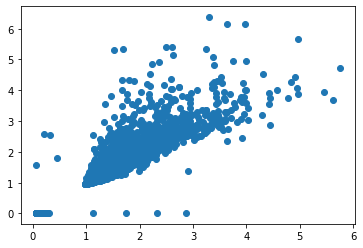

In [18]:
# Compare prediction and actual
arma_y_pred = arma_model.predict(params = arma_model_fitted.params)
y_true = df_train['Hydrometry_Nave_di_Rosano']

#plt.plot(arma_y_pred)
#plt.plot(y_true)
plt.scatter(arma_y_pred,y_true)
plt.show()

## VAR forecasting model

In [19]:
# Initialise model
var_model = VAR(df_train)

In [20]:
# Parameters
maxvarlags = 5

# Model selection
x = var_model.select_order(maxlags=maxvarlags)
x.summary() # Order 1 seems to be the best

,AIC,BIC,FPE,HQIC
0,30.34,30.36,1.502e+13,30.35
1,24.91,25.19*,6.600e+10,25.01
2,24.79,25.33,5.814e+10,24.97*
3,24.74,25.56,5.579e+10,25.03
4,24.74,25.82,5.576e+10,25.12
5,24.74*,26.08,5.566e+10*,25.21


In [21]:
# Fit the model with the selected order
var_model_fitted = var_model.fit(1)
var_model_fitted.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Mon, 14, Dec, 2020
Time:                     11:17:50
--------------------------------------------------------------------
No. of Equations:         16.0000    BIC:                    25.1845
Nobs:                     6573.00    HQIC:                   25.0007
Log likelihood:          -230800.    FPE:                6.53831e+10
AIC:                      24.9035    Det(Omega_mle):     6.27361e+10
--------------------------------------------------------------------
Results for equation Rainfall_Le_Croci
                                  coefficient       std. error           t-stat            prob
-----------------------------------------------------------------------------------------------
const                                3.165126         0.332377            9.523           0.000
L1.Rainfall_Le_Croci                 0.052435         0.036300            1.445     

In [43]:
# Parameters
forecast_horizon = 1
target_name = 'Hydrometry_Nave_di_Rosano'
target_loc = list(df_train.columns).index(target_name)
d = df_train.shape[1]



var_y_pred = []
counter = 0

for i in range(0,len(df_train)):
    
    forecast_input = df_train.values[i,:].reshape(1,d)
    
    #print(forecast_input)
        
    # Forecast step
    fc = var_model_fitted.forecast(y=forecast_input, steps=forecast_horizon)
    
    #sprint(fc)
    
    # Find the target value
    pred = fc[forecast_horizon-1,target_loc]
    #print(pred)
    var_y_pred.append(pred)
    
    # Increment counter
    counter += 1

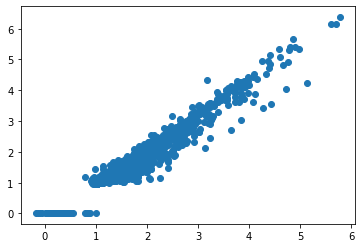

In [44]:
# Compare prediction and actual
plt.scatter(var_y_pred,y_true)
plt.show()